In [1]:
import numpy as np
from scipy.stats import invgamma
from scipy.stats import norm

import pandas as pd

In [2]:
data = pd.read_csv("HistoricalData.csv").set_index("Date")
btc_open = data["Open"]
print(data.columns)
btc_open

Index(['Close/Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')


Date
01/28/2024    42717.5
01/27/2024    41840.9
01/26/2024    39936.2
01/25/2024    39948.4
01/24/2024    39654.2
               ...   
03/12/2019     3870.3
03/11/2019     3915.6
03/10/2019     3944.3
03/09/2019     3865.9
03/08/2019     3875.1
Name: Open, Length: 1717, dtype: float64

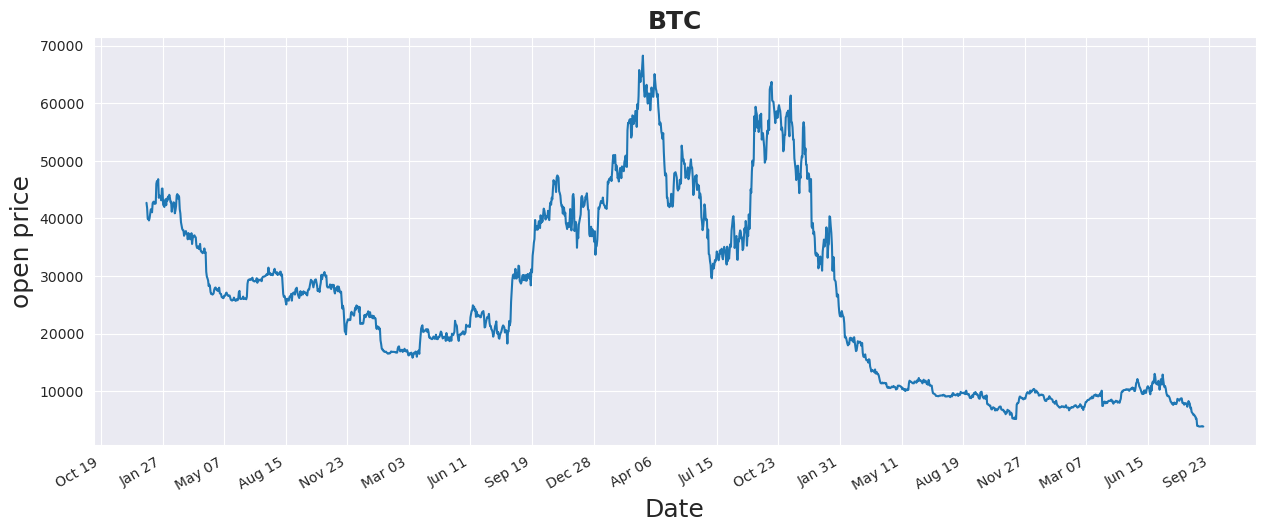

In [3]:
from utils import visualize

visualize.draw(btc_open, ylabel="open price")

## Daily Return 

$$
R_i=\frac{o_{i+1}-o_{i}}{o_{i}}
$$

In [4]:
data["Return"] = (data["Open"].shift(1) - data["Open"])/data["Open"]
data["Return"] = data["Return"].fillna(0)

data["Return"]

Date
01/28/2024    0.000000
01/27/2024    0.020951
01/26/2024    0.047694
01/25/2024   -0.000305
01/24/2024    0.007419
                ...   
03/12/2019    0.004470
03/11/2019   -0.011569
03/10/2019   -0.007276
03/09/2019    0.020280
03/08/2019   -0.002374
Name: Return, Length: 1717, dtype: float64

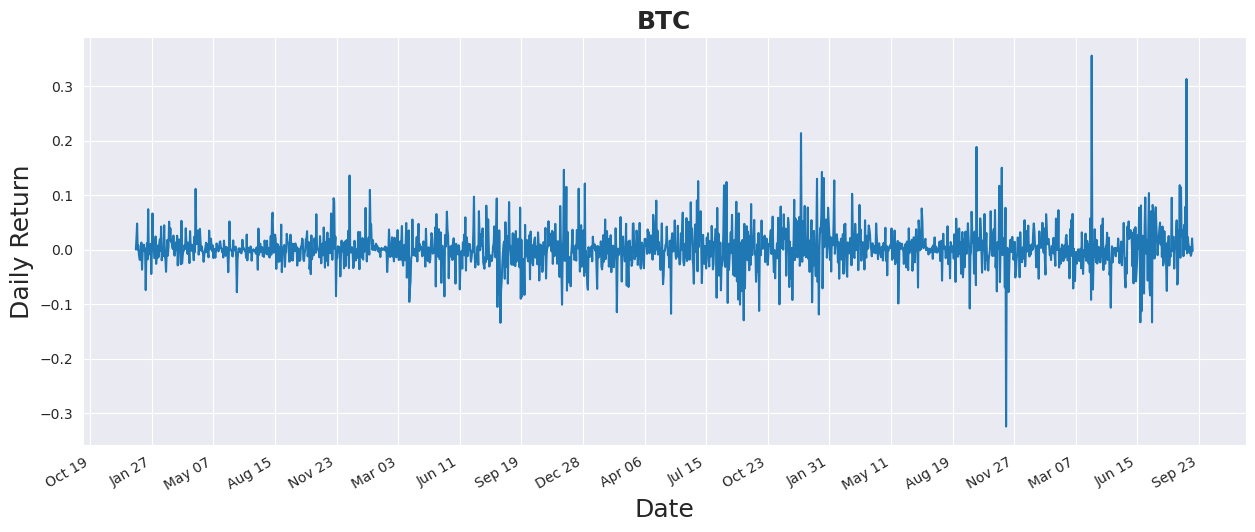

In [5]:
visualize.draw(data["Return"], ylabel="Daily Return")

### Log Returns

$$
R^L_i=\ln (\frac{o_{i+1}}{o_i})
$$

In [6]:
data["Log"] = np.log(data["Open"].shift(1)/data["Open"])
data["Log"] = data["Log"].fillna(0)

data["Log"]

Date
01/28/2024    0.000000
01/27/2024    0.020734
01/26/2024    0.046591
01/25/2024   -0.000305
01/24/2024    0.007392
                ...   
03/12/2019    0.004460
03/11/2019   -0.011637
03/10/2019   -0.007303
03/09/2019    0.020077
03/08/2019   -0.002377
Name: Log, Length: 1717, dtype: float64

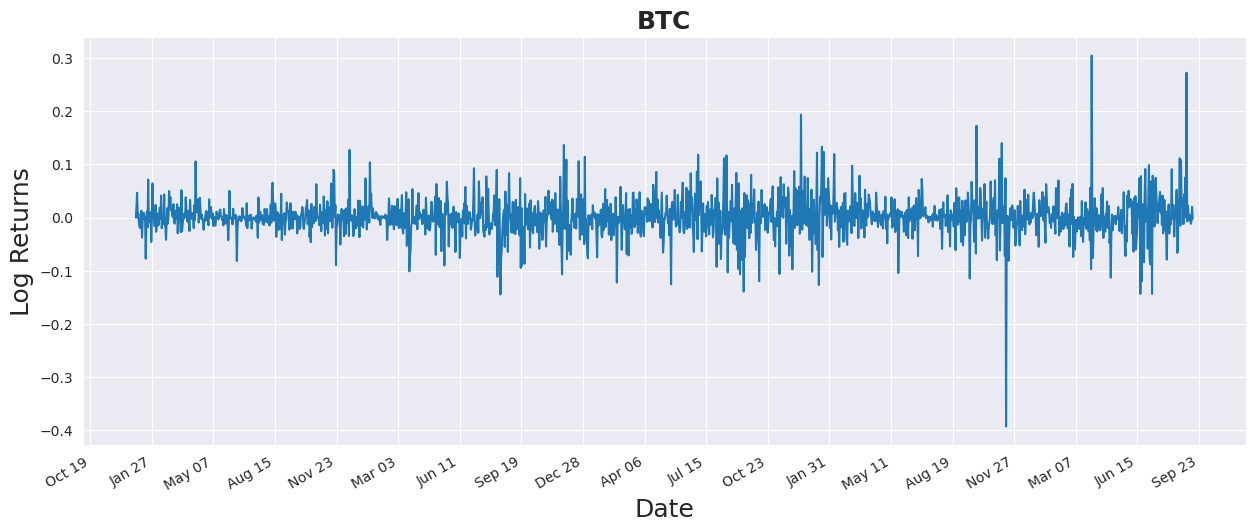

In [7]:
visualize.draw(data["Log"], ylabel="Log Returns")

In [8]:
mean_ = data["Log"].mean()
sum_ = data["Log"].sum()
sigma2_ = data["Log"].std()**2
n_ = data["Log"].size

print(mean_, sum_, sigma2_, n_)

0.0013978085051929794 2.4000372034163457 0.0013749970883640916 1717


# Gibbs Sampling

- references:
    - https://www.youtube.com/watch?v=dclTzszTMNQ
    - https://www.statisticshowto.com/inverse-gamma-distribution/
    - https://stats.stackexchange.com/questions/512681/posterior-distribution-of-normal-normal-inverse-gamma-conjugacy
    - https://www.cs.ubc.ca/%7Emurphyk/Papers/bayesGauss.pdf

our data, log returns are following normal distribution, with unknown parameters $\mu$ and $\sigma^2$.

$$
R\sim N(\mu,\sigma^2)
$$

further, we assume $\mu$ follows another normal distribution:

$$
\mu \sim N(\mu_0, \sigma_0^2),~f(\mu|\mu_0,\sigma_0^2)=\frac1{\sqrt{2\pi\sigma_0^2}}e^{-\frac12(\frac{\mu-\mu_0}{\sigma_0})^2}
$$

and we assume $\sigma^2$ follows a inverse Gamma distribution:

$$
\sigma^2 \sim inv-Ga(\alpha, \beta),~f(\sigma^2|\alpha,\beta)=\frac 1{\Gamma(\alpha)}\frac{\beta^\alpha}{\sigma^{2\alpha+2}}e^{-\beta/\sigma^2}
$$

In [9]:
from utils import distributions as d

with given data, we could derive the posterior conditional distribution for these two parameters:

$$
\mu| X \sim N({\sigma^2\mu_0+\sigma_0^2 nE(X)\over\sigma^2+n\sigma_0^2},{\sigma^2\sigma_0^2\over\sigma^2+n\sigma_0^2})
$$

$$
\sigma^2| X \sim inv-Ga(\alpha+\frac n2,\beta+\frac12\sum_{i=1}^n(x_i-\mu)^2)
$$

In [10]:
mu_L, sigma2_L, index = d.gibbs_sample(data["Log"], 5000)

## Visualization

- [x] Running Mean
- [x] Creditable Interval
- [x] Auto correlation -> 0

In [11]:
from utils import visualize as vs

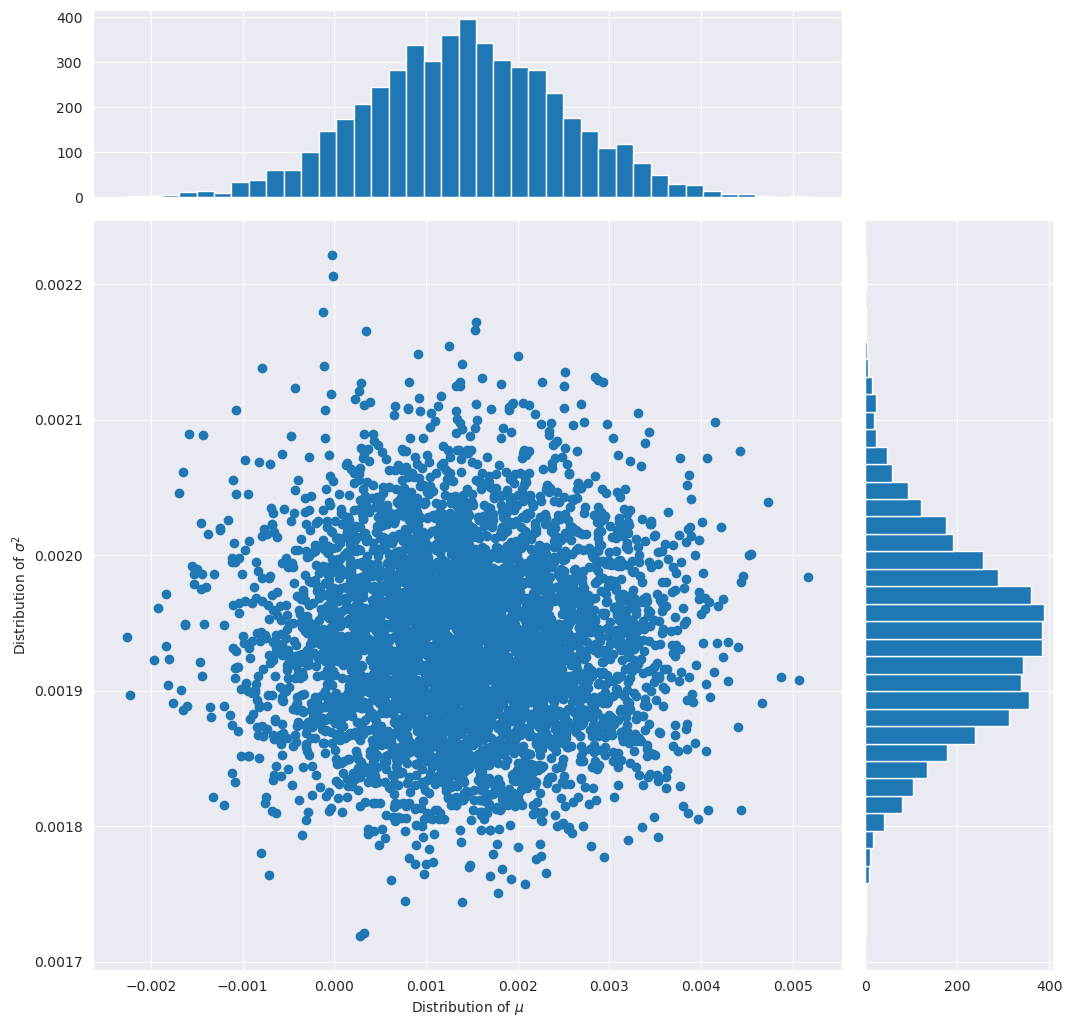

In [12]:
vs.show_distribution(mu_L, sigma2_L)

## Autocorrelation

In [13]:
from utils import visualize as vs

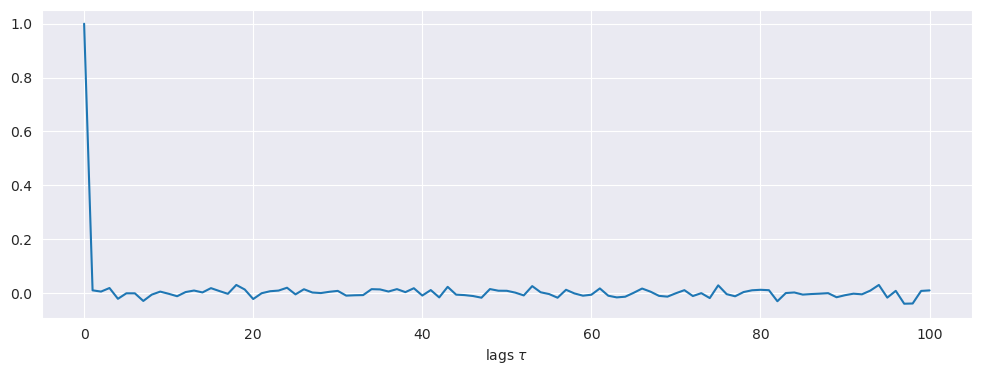

In [14]:
vs.show_corr(mu_L)

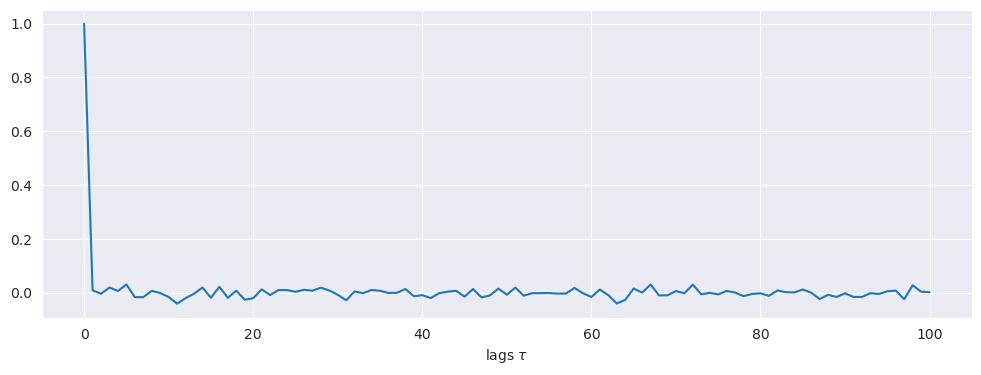

In [15]:
vs.show_corr(sigma2_L)

### Running Time Average

In [16]:
import matplotlib.pyplot  as plt

In [17]:
mu_ra = np.cumsum(mu_L, dtype=float)
mu_ra /= index + 1

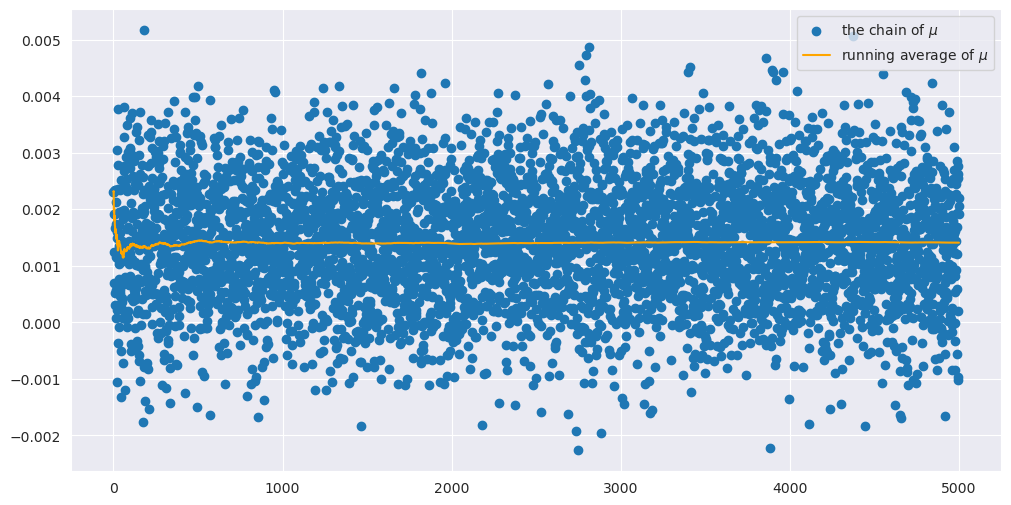

In [18]:
plt.figure(figsize=(12, 6))
plt.scatter(x=index, y=mu_L, label=r"the chain of $\mu$")
plt.plot(index, mu_ra, color="orange", label=r"running average of $\mu$")
plt.legend()

In [19]:
sigma2_ra = np.cumsum(sigma2_L, dtype=float)
sigma2_ra /= index + 1

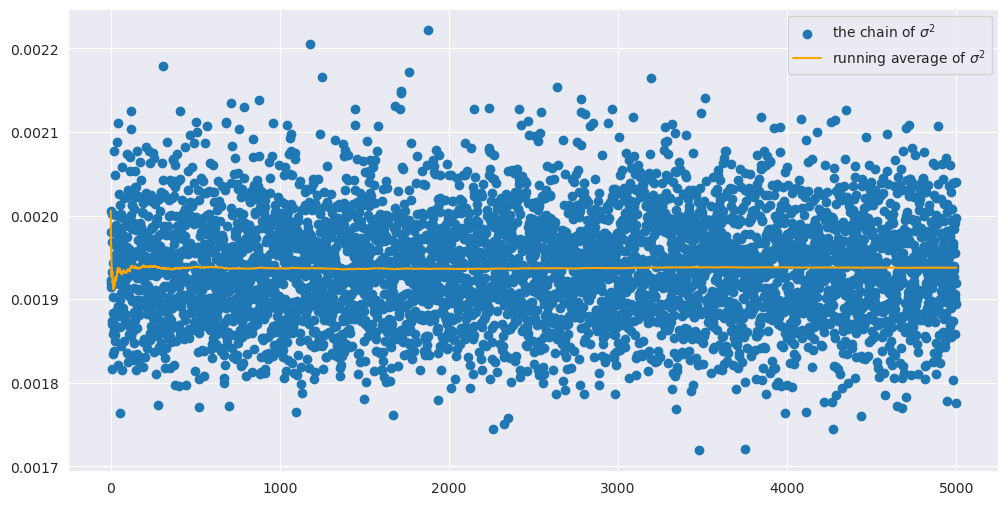

In [20]:
plt.figure(figsize=(12, 6))
plt.scatter(x=index, y=sigma2_L, label=r"the chain of $\sigma^2$")
plt.plot(index, sigma2_ra, color="orange", label=r"running average of $\sigma^2$")
plt.legend()

## Credible Interval

In [21]:
from scipy import stats

def credible_interval(data, confidence_level=0.995):
    lower, upper = stats.mstats.mquantiles(data, [1 - confidence_level, confidence_level])
    return lower, upper

In [22]:
mu_CI = credible_interval(mu_L)
mu_CI

(-0.0014431239305528944, 0.004072987400436522)

In [23]:
sigma2_CI = credible_interval(sigma2_L)
sigma2_CI

(0.0017837507891294037, 0.002124498971195289)

And their corresponding credible interval ($\alpha=0.01$):

$$
\mu\in[1.391\times10^{-3},1.404\times10^{-3}]\\
$$
$$
\sigma^2\in[1.789\times10^{-3}, 2.146\times10^{-3}]
$$

# VaR

In [24]:
from scipy.stats import norm
from utils import visualize as vs

In [25]:
VaR = []

for _mu in mu_CI:
    for _sigma2 in sigma2_CI:
        VaR.append(norm.ppf(0.005, _mu, np.sqrt(_sigma2)))

print(min(VaR), max(VaR))

-0.12016898885836333 -0.10471580819848346


$$
\text{VaR}\in [-0.1178,-0.1077]
$$

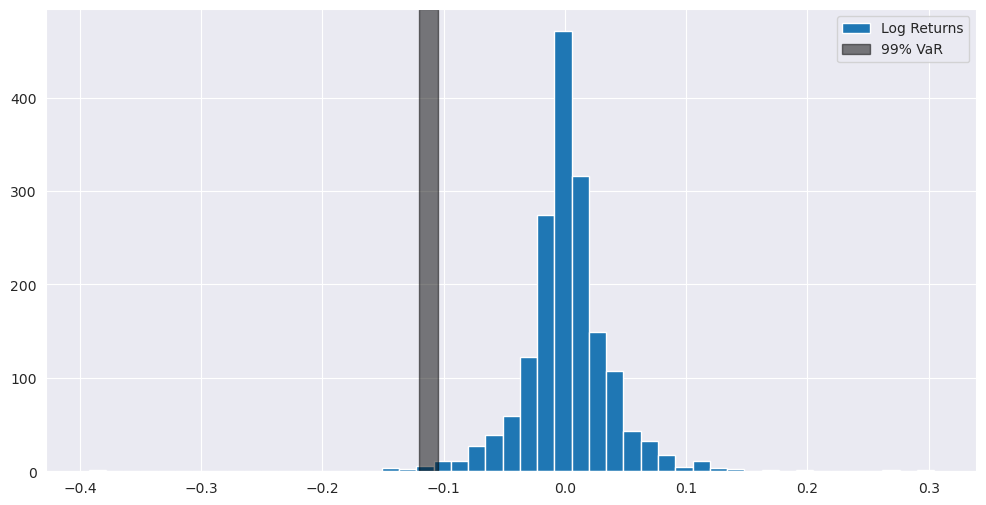

In [26]:
vs.show_VaR(data["Log"], VaR)

# Expected Shortfall

In [27]:
condition1 = data["Log"][data["Log"] < min(VaR)]
condition1.mean()

condition2 = data["Log"][data["Log"] < max(VaR)]
condition2.mean()

ES = [condition1.mean(), condition2.mean()]
ES

[-0.16720015974567634, -0.13970491980887262]

$$
\text{ES}\in [-0.1577,-0.1473]
$$

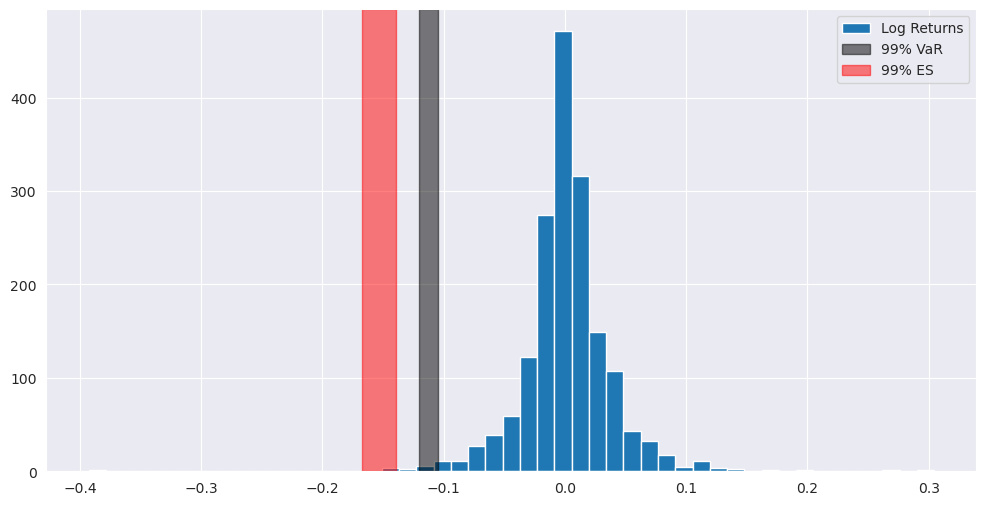

In [28]:
vs.show_VaR_ES(data["Log"], VaR, ES)